In [1]:
# Segment cells with Stardist. This seems to work well and provide good results :)
# Tracking the cells is a major issue. Use pips++ model to track the individual segmented points using the first frame's coordinates
# Use subsequent frames to with stardist to verify that pips++ is on the right track, reinitialize if drifting
# can split the video into multiple segments and track all of them in parallel, then merge the tracks with a nearest neighbors algorithm


In [2]:
# Load stardist model. From testing, cell seg works well too. No GPU here so this will all be much slower
# Tracking with PIPs will also be much slower. Will need to figure something out here

In [1]:
from rebirth.utils import stardist_utils as std
from rebirth.utils import tif_memmap_utils as utils, display_utils as disp

%load_ext autoreload
%autoreload 2

In [21]:
# stardist model
model_path = r'C:\Users\jl5675\Desktop\Noah\github\rebirth2024\models\stardist'

model = std.stardist(model_path)
model.prob_threshold = 0.37
model.nms_threshold = 0.42

Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.525691, nms_thresh=0.3.


In [3]:
# pth = r'C:\Users\jl5675\Desktop\Noah\data\rebirth\redSamsungDrive\Animal7_rec1\20230710_09_50pm_1stRecording_24hrPostSedimentation_200ms_Exposure_10sInterval_7mw_Yellow_250msExposure_50mw_Blue_Burstevery7hrs_for20mins_1stRecording\npy_test\channel2.npy'
# mta = r'C:\Users\jl5675\Desktop\Noah\data\rebirth\redSamsungDrive\Animal7_rec1\20230710_09_50pm_1stRecording_24hrPostSedimentation_200ms_Exposure_10sInterval_7mw_Yellow_250msExposure_50mw_Blue_Burstevery7hrs_for20mins_1stRecording\npy_test\channel2_meta.json'
# data = utils.open_memmap(pth, mta)

In [3]:
path_to_memmap_2 = r'C:\Users\jl5675\Desktop\Noah\data\rebirth\redSamsungDrive\Animal7_rec1\20230710_09_50pm_1stRecording_24hrPostSedimentation_200ms_Exposure_10sInterval_7mw_Yellow_250msExposure_50mw_Blue_Burstevery7hrs_for20mins_1stRecording\numpy\camera2_1.npy'
path_to_metadata_2 = r'C:\Users\jl5675\Desktop\Noah\data\rebirth\redSamsungDrive\Animal7_rec1\20230710_09_50pm_1stRecording_24hrPostSedimentation_200ms_Exposure_10sInterval_7mw_Yellow_250msExposure_50mw_Blue_Burstevery7hrs_for20mins_1stRecording\numpy\camera2_1_meta.json'

In [4]:
# cam1_data = utils.open_memmap(path_to_memmap_2, path_to_metadata_2) # green
cam2_data = utils.open_memmap(path_to_memmap_2, path_to_metadata_2) # red

In [5]:
disp.cv_play(cam2_data)


In [4]:
stats = utils.open_metadata(mta, field_name = 'image_statistics')

In [5]:
mini = stats['bottom_quantile']
maxi = stats['top_quantile']

In [ ]:
type(mini)
int(mini)

In [5]:
# normalise this data!

batch = cam2_data[0:50]

normvid = std.normalizer(batch) # this copies data

In [22]:
#segment the data

detections, data = model.detect(normvid)

100%|██████████| 50/50 [05:09<00:00,  6.20s/it]


In [ ]:
data[0]['points']

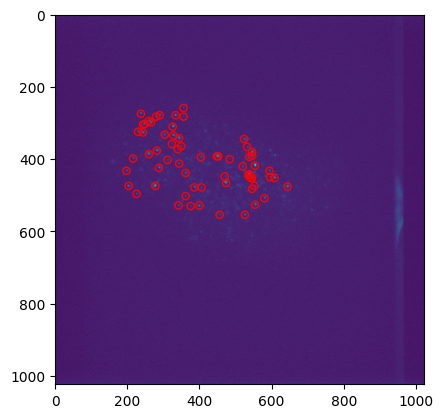

In [38]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
# %matplotlib tk

radius = 10

fig, ax = plt.subplots()
ax.imshow(batch[0])

for centroid in data[0]['points']:
    circle = patches.Circle( (centroid[1], centroid[0]), radius, edgecolor = 'r', facecolor = 'none')
    ax.add_patch(circle)

plt.show()

In [40]:
#Set model parameters for your dataset
detector = model
vidCopy = normvid[0:20] #test batch
scale = 1
import cv2
global frameID
global frame
global frame_cv
global contours

frameID = 0
frame = vidCopy[frameID].copy()
frame_cv = cv2.normalize(src=frame, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
frame_cv = cv2.cvtColor(frame_cv, cv2.COLOR_GRAY2BGR)
h, w = frame.shape[0:2]

#initialise plotting parameters with default values - converted to 0-100 range for openCV trackbars
probabilityThreshold = int(detector.prob_threshold*100) 
nmsThreshold = int(detector.nms_threshold*100)

contours = std.generate_contours(frame, detector) 

# window_name = 'Frame', f'Frame {frameID} / {len(detections_sequence_test)} - Number of detections: {len(detections_sequence_test[i])}'
window_name = 'Parameter Test - Segmentation   (Press Q to Quit)'

try:

    #create and rescale window
    cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
    cv2.resizeWindow(window_name, h*scale, w*scale)

    #Frame Trackbar
    def update_frame(x): #callback function for trackbar - default argument is the position of the track bar
        global contours
        global frame
        global frame_cv

        frame = vidCopy[x].copy()
        frame_cv = cv2.normalize(src=frame, dst=None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
        frame_cv = cv2.cvtColor(frame_cv, cv2.COLOR_GRAY2BGR)
        contours = std.generate_contours(frame, detector) 
    cv2.createTrackbar('Frame',window_name,0,len(vidCopy)-1,update_frame)

    #Probability Trackbar
    def update_probability_threshold(x):
        detector.prob_threshold = (x+1)/100 
        update_frame(frameID)
    cv2.createTrackbar('Probability Threshold', window_name, probabilityThreshold, 99, update_probability_threshold)

    #Overlap Trackbar
    def update_overlap_threshold(x):
        detector.nms_threshold = (x+1)/100
        update_frame(frameID)
    cv2.createTrackbar('Overlap Threshold', window_name, nmsThreshold, 99, update_overlap_threshold)

except Exception as e:
    print(e)


while True:
    try:

        frameID = cv2.getTrackbarPos('Frame',window_name)
        # cv2.imshow(window_name, video[frameID])
        std.visualise_all_contours_cv(frame_cv, contours)
        cv2.imshow(window_name, frame_cv)

        probabilityThreshold = cv2.getTrackbarPos('Probability Threshold', window_name)/100
        nmsThreshold = cv2.getTrackbarPos('Overlap Threshold', window_name)/100

        #exit on q
        if cv2.waitKey(5) == ord('q'):
            # press q to terminate the loop
            cv2.destroyAllWindows()
            break

    except Exception as e:
        print(e)
        cv2.destroyAllWindows()
        break
    
cv2.destroyAllWindows()

print('Probability Threshold: ', probabilityThreshold)
print('nms Threshold: ', nmsThreshold)

Probability Threshold:  0.11
nms Threshold:  0.12


In [9]:
# need to normalize or things look bad